Make initial conditions for a fantastic continent island

Staring with a continental plateou,

Structure is given in a scale free gaussian random field approximation



In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML

import skimage.transform as sktransform 
from skimage import color, morphology

plt.rcParams["animation.html"] = "jshtml"

In [84]:
def distance_kernel(half_extent=50):
    size = half_extent * 2 + 1
    kernel = np.zeros((size, size))
    vals = np.arange(-half_extent,half_extent+1)
    xx, yy = np.meshgrid(vals, vals, indexing='xy')
    # y, x = np.ogrid[-half_extent:half_extent+1, -half_extent:half_extent+1]
    distance = np.sqrt(xx**2 + yy**2)
    return distance
    
def tophat(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel[dists < radius] = 1
    kernel = kernel / kernel.sum()
    return kernel

def gaussian(dists, scale=50.):
    kernel = np.zeros(dists.shape)
    kernel = np.exp(- dists**2. / (2 * scale**2.))
    kernel = kernel / kernel.sum()
    return kernel

def triangle(dists, scale=50):
    """triangle kernel, scale is when it hits zero"""
    kernel = np.zeros(dists.shape)
    kernel = scale - dists
    kernel[kernel < 0] = 0
    kernel = kernel / kernel.sum()
    return kernel

kernels = {
    "gauss": gaussian,
    "tophat": tophat,
    "triangle": triangle,
}

def make_noise_map(scale, shape, which="gauss"):
    num = shape[0] * shape[1]
    noise = np.random.uniform(size=num).reshape(shape)
    dists = distance_kernel(half_extent=scale*3)
    
    
    kern = kernels[which](dists, scale=scale)
    tmp = np.fft.irfft2(np.fft.rfft2(noise) * np.fft.rfft2(kern, noise.shape))
    tmp = tmp - tmp.min()
    tmp = tmp / tmp.max()
    
    return tmp

def convolve_map(canvas, scale, which = "gauss",):
    pad_width = scale*3
    padded = np.pad(canvas, pad_width = scale*3)
    half_extent = scale*2
    dists = distance_kernel(half_extent = half_extent)    
    kern = kernels[which](dists, scale = scale)
    
    # There's some shape difference here, which needs to be manually corrected with the padding
    # just offset the convolved image by the half_extent of the kernel...
    tmp = np.fft.irfft2(np.fft.rfft2(padded) * np.fft.rfft2(kern, padded.shape))
    tmp = tmp[pad_width+half_extent:-pad_width+half_extent, pad_width+half_extent:-pad_width+half_extent]
    return tmp

In [274]:
raw_canvas = np.zeros(shape = (1000, 1000))
bins = np.linspace(0, 20, 1001)
bcens = bins[:-1] + np.diff(bins) / 2


np.random.seed(5)
samples0 = np.random.multivariate_normal((10, 10), cov=np.eye(2)* 30, size=int(1e7))
land0 = np.histogram2d(samples0[:, 0], samples0[:, 1], bins=(bins, bins))[0]
land = land0 / land0.max() * 3000.


res = make_noise_map(2, raw_canvas.shape)
res = res / res.max() * 1000
land += res

res = make_noise_map(4, raw_canvas.shape)
res = res / res.max() * 1000
land += res

res = make_noise_map(6, raw_canvas.shape)
res = res / res.max() * 1000
land += res

res = make_noise_map(18, raw_canvas.shape)
res = res / res.max() * 1000
land += res

res = make_noise_map(39, raw_canvas.shape)
res = res / res.max() * 1000
land += res

res = make_noise_map(80, raw_canvas.shape)
res = res / res.max() * 1000
land += res


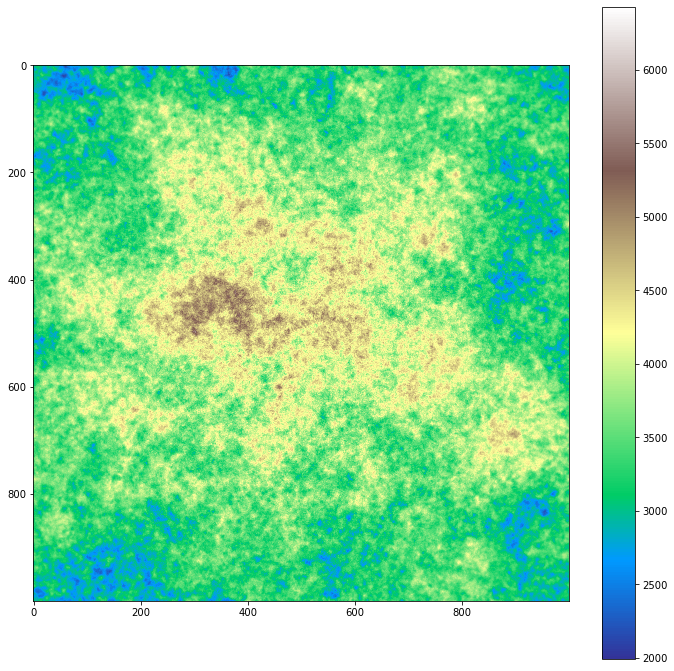

In [275]:

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
im = ax.imshow(land, cmap=plt.cm.terrain)
plt.colorbar(im)

This looks really promising, let's 

In [276]:
characteristic_heights = {
    "peak": 6000,  # The highest point in the land measured from the seabed
    "laverage": 1500, # The averagge height of land above water
    "sealevel": 1200, # the sealevel
    "plateau": 1000, # The height of the continental plateau
}

In [326]:
#The peak is just a simple operation
terrain = land.copy()
terrain -= terrain.min()
terrain = terrain / terrain.max() * characteristic_heights["peak"]

# now implement the continental plateau creation, this is a filtered dampening process
seabed = np.ones(shape=terrain.shape)
ii = terrain < characteristic_heights["plateau"]
# jj = terrain < characteristic_heights["sealevel"]
seabed[ii] = 0.
seabed = convolve_map(seabed, 1000, which="triangle")
terrain *= seabed
ii = terrain < characteristic_heights["plateau"]
fac = (terrain[ii] / (characteristic_heights["plateau"] * 4)) - 1
terrain[ii] = np.exp(fac *10)


terrain = terrain / terrain.max() * characteristic_heights["peak"]


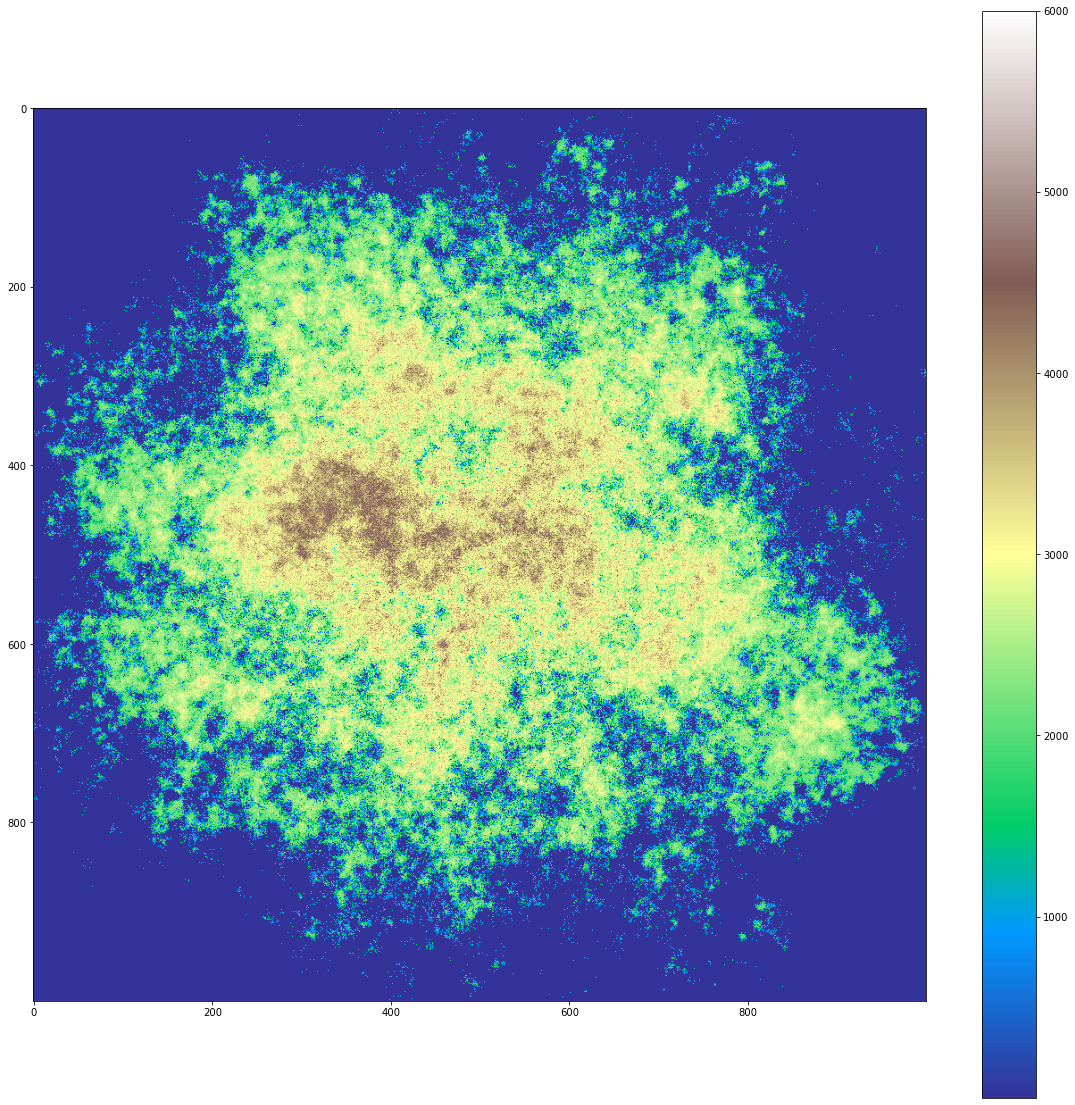

In [327]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.imshow(terrain, cmap=plt.cm.terrain)
plt.colorbar(im)

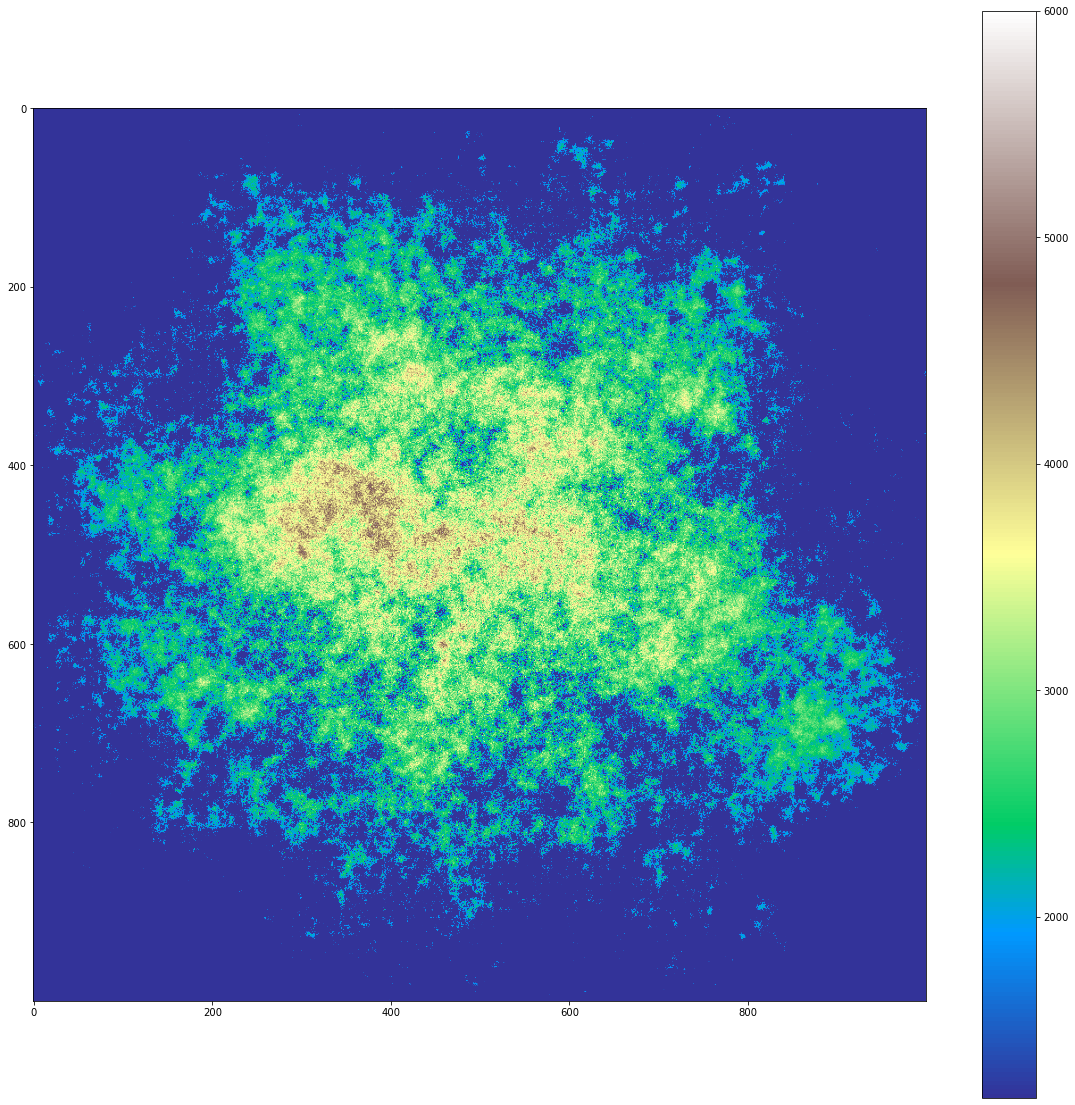

In [328]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.imshow(terrain, cmap=plt.cm.terrain, vmin=1200)
plt.colorbar(im)

In [291]:
terrain[terrain > 1200 ].mean()

2258.979068008611